In [3]:
#install unzip in notebook
!sudo apt-get install -y unzip zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unzip zip
0 upgraded, 2 newly installed, 0 to remove and 50 not upgraded.
Need to get 335 kB of archives.
After this operation, 1231 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 unzip amd64 6.0-25ubuntu1.1 [168 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 zip amd64 3.0-11build1 [167 kB]
Fetched 335 kB in 1s (480 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 25583 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-25ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-25ubuntu1.1) ...
Selecting previously unselected package zip.
Preparing to unpack .../zip_3.0-11build1_amd64.deb ...
Unpacking zip (3.0-11build1) ...
Setting up unzip (6.0-25ubuntu1.1) .

In [76]:
!pip install boto3 datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.97
    Uninstalling botocore-1.29.97:
      Successfully uninstalled botocore-1.29.97
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.6.0
    Uninstalling s3transfer-0.6.0:
      Successfully uninstalled s3transfer-0.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 0.4.2 requires botocore>=1.12.91, but you have botocore 1.8.50 which is incompatible.
awscli 1.27.97 requires botocore==1.29.97, but you have botocore 1.8.50 which is incompatible.
awscli 1.27.97 requires s3transfer<0.7.0,>=0.6.0, but you have s3transfer 0.1.13 which is incompatible.

[notice] A new release of pip i

In [38]:
import boto3

s3 = boto3.resource('s3', endpoint_url='https://storage.s3.mlops.wogra.com')
bucket = s3.Bucket('data')

In [9]:
bucket.download_file('dlr/dataset_tapelegen.zip', 'data.zip')

In [10]:
# extreact zip file to data folder
!rm -r data
!unzip data.zip -d data

Archive:  data.zip
   creating: data/dataset_tapelegen/
  inflating: data/dataset_tapelegen/dataset_info.json  
  inflating: data/dataset_tapelegen/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/state.json  
  inflating: data/dataset_tapelegen/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/data-00002-of-00003.arrow  
 extracting: data/dataset_tapelegen/dataset_dict.json  
   creating: data/dataset_tapelegen/train/
  inflating: data/dataset_tapelegen/train/dataset_info.json  
  inflating: data/dataset_tapelegen/train/data-00001-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/state.json  
  inflating: data/dataset_tapelegen/train/data-00000-of-00003.arrow  
  inflating: data/dataset_tapelegen/train/data-00002-of-00003.arrow  


In [11]:
!pip install datasets


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [12]:
# create a dataset for images in the folders and use the folder name as label
from datasets import load_from_disk

dataset = load_from_disk("data/dataset_tapelegen/")

# take random seed of examples from dataset
dataset = dataset.shuffle(seed=42)
dataset


Loading cached shuffled indices for dataset at /home/jovyan/work/data/dataset_tapelegen/cache-fffa42af9c821476.arrow


Dataset({
    features: ['image', 'label'],
    num_rows: 73749
})

In [13]:
# remove all items from dataset with mean 0 but dont use remove rows which not exists as method
import numpy as np
clean_dataset = dataset.filter(lambda example: np.mean(example["image"]) != 0)
clean_dataset

Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-2ec92fc4d37af4eb.arrow


In [15]:
!pip install transformers==4.26.1 evaluate


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [18]:
import transformers

checkpoint = "google/vit-base-patch16-224-in21k"

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    checkpoint
)
print(feature_extractor.size)
print(feature_extractor.image_mean)
print(feature_extractor.image_std)

{'height': 224, 'width': 224}
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


In [19]:
labels = clean_dataset.features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [20]:
id2label

{'0': 'g', '1': 'n', '2': 'o'}

In [21]:
label2id

{'g': '0', 'n': '1', 'o': '2'}

In [22]:
labelids = [int(id) for id in id2label.keys()]

In [23]:

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:

from transformers import TrainingArguments

batch_size = 14*16

training_args = TrainingArguments(
    output_dir="my_tapelegen_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


In [25]:
import evaluate
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [26]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [29]:
sorted_datasets = [clean_dataset.filter(lambda example: example["label"] == labelid, batch_size=1024) for labelid in labelids]
sorted_datasets[0]

Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-1ec5ee3afb565a54.arrow
Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-a9940fc71d5427d0.arrow
Loading cached processed dataset at /home/jovyan/work/data/dataset_tapelegen/cache-7a08c809abd2881d.arrow


Dataset({
    features: ['image', 'label'],
    num_rows: 8707
})

In [30]:
# get the minimum number of examples in the dataset with respect to the label
min_examples = min(data.num_rows for data in sorted_datasets)
min_examples

3248

In [31]:
from datasets import concatenate_datasets

weighted_dataset = concatenate_datasets(
    [
        fd.shuffle(seed=42).select(range(min_examples)) for fd in sorted_datasets
    ]  
)

weighted_dataset.num_rows - 3*min_examples

0

In [32]:
# 90% train, 10% test + validation
split_one = weighted_dataset.train_test_split(test_size=0.2, seed=42)

In [33]:
# Split the 10% test + valid in half test, half valid
split_two = split_one['test'].train_test_split(test_size=0.5, seed=42)

In [36]:
from datasets import DatasetDict

train_test_valid_dataset = DatasetDict({
    "train": split_one["train"],
    "validate": split_two["train"],
    "test": split_two["test"]})


In [40]:
train_test_valid_dataset.save_to_disk("train_test_valid_dataset")
!zip -r train_test_valid_dataset.zip train_test_valid_dataset 
bucket.upload_file('train_test_valid_dataset.zip', 'dlr/train_test_valid_dataset.zip')

updating: train_test_valid_dataset/ (stored 0%)
updating: train_test_valid_dataset/dataset_dict.json (deflated 2%)
updating: train_test_valid_dataset/validate/ (stored 0%)
updating: train_test_valid_dataset/validate/dataset_info.json (deflated 52%)
updating: train_test_valid_dataset/validate/state.json (deflated 40%)
updating: train_test_valid_dataset/validate/data-00000-of-00001.arrow (deflated 2%)
updating: train_test_valid_dataset/train/ (stored 0%)
updating: train_test_valid_dataset/train/dataset_info.json (deflated 52%)
updating: train_test_valid_dataset/train/state.json (deflated 40%)
updating: train_test_valid_dataset/train/data-00000-of-00001.arrow (deflated 2%)
updating: train_test_valid_dataset/test/ (stored 0%)
updating: train_test_valid_dataset/test/dataset_info.json (deflated 52%)
updating: train_test_valid_dataset/test/state.json (deflated 40%)
updating: train_test_valid_dataset/test/data-00000-of-00001.arrow (deflated 2%)


In [41]:
from torchvision import transforms
import numpy as np

def preprocess(image):
    # convert image to tensor
    tensor = transforms.ToTensor()(image)
    tensor = tensor - np.mean(tensor.numpy()) + 128
    tensor[tensor < 0] = 0
    tensor[tensor > 255] = 255
    tensor = tensor / 255
    # repeat the tensor two ore times to get 3 channels and use the repeat function
    tensor = tensor.repeat(3, 1, 1)
    return tensor


class Preprocess:
    def __init__(self):
        self.transforms = transforms.Compose(
            [
                transforms.Lambda(preprocess),
                transforms.CenterCrop(224),
            ]
        )

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [
            self.transforms(img) for img in example_batch["image"]
        ]
        del example_batch["image"]
        return example_batch

train_test_valid_dataset.set_transform(Preprocess())


In [42]:
model.to('cuda')

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [43]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["validate"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [44]:
trainer.train()

/home/ray/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7795
  Num Epochs = 10
  Instantaneous batch size per device = 224
  Total train batch size (w. parallel, distributed & accumulation) = 2688
  Gradient Accumulation steps = 4
  Total optimization steps = 30
  Number of trainable parameters = 85800963
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 974
  Batch size = 672
  Num examples = 974
  Batch size = 672
Saving model checkpoint to my_tapelegen_model/checkpoint-3
Configuration saved in my_tapelegen_model/checkpoint-3/config.json
Saving model checkpoint to my_tapelegen_model/checkpoint-3
Configuration saved in my_tapelegen_model/checkpoint-3/config.json
Model weights saved in my_tapelegen_model/checkpoint-3/pytorch_model.bin
Image processor saved in my_tapelegen_model/checkpoint-3/preprocessor_config.json
/home/ray/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 974
  Batch size = 672
Saving model checkpoint to my_tapelegen_model/checkpoint-6
Configuration saved in my_tapelegen_model/checkpoint-6/config.json
Mod

TrainOutput(global_step=30, training_loss=0.5673558076222738, metrics={'train_runtime': 378.8442, 'train_samples_per_second': 205.757, 'train_steps_per_second': 0.079, 'total_flos': 6.040554729553613e+18, 'train_loss': 0.5673558076222738, 'epoch': 10.0})

In [45]:
trainer.state.log_history

[{'eval_loss': 1.0313174724578857,
  'eval_accuracy': 0.7525667351129364,
  'eval_runtime': 2.7348,
  'eval_samples_per_second': 356.154,
  'eval_steps_per_second': 0.731,
  'epoch': 1.0,
  'step': 3},
 {'eval_loss': 0.8224616646766663,
  'eval_accuracy': 0.9137577002053389,
  'eval_runtime': 2.6111,
  'eval_samples_per_second': 373.029,
  'eval_steps_per_second': 0.766,
  'epoch': 2.0,
  'step': 6},
 {'eval_loss': 0.6634659171104431,
  'eval_accuracy': 0.9240246406570842,
  'eval_runtime': 2.6269,
  'eval_samples_per_second': 370.782,
  'eval_steps_per_second': 0.761,
  'epoch': 3.0,
  'step': 9},
 {'loss': 0.917,
  'learning_rate': 3.7037037037037037e-05,
  'epoch': 3.33,
  'step': 10},
 {'eval_loss': 0.5364565253257751,
  'eval_accuracy': 0.9322381930184805,
  'eval_runtime': 2.6217,
  'eval_samples_per_second': 371.509,
  'eval_steps_per_second': 0.763,
  'epoch': 4.0,
  'step': 12},
 {'eval_loss': 0.44699034094810486,
  'eval_accuracy': 0.9322381930184805,
  'eval_runtime': 2.742,

In [46]:
# iterate over the log history and collect the value eval_loss in a list if the key exists in the dict item
eval_loss = [item["eval_loss"] for item in trainer.state.log_history if "eval_loss" in item.keys()]

In [47]:
# now collect the accuracy in a list ehich has the key eval_accuracy
eval_accuracy = [item["eval_accuracy"] for item in trainer.state.log_history if "eval_accuracy" in item.keys()]

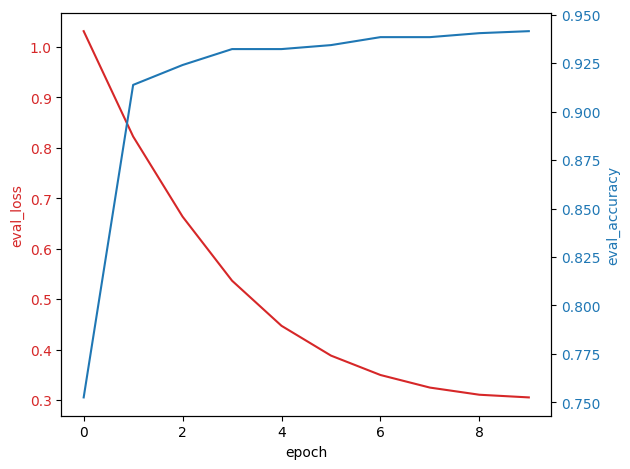

In [48]:
# plot eval loss and accuracy in the same plot with two y axis

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('eval_loss', color=color)
ax1.plot(eval_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('eval_accuracy', color=color)
ax2.plot(eval_accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In [49]:
# get local checkpoints of trained model
trainer.save_model("my_best_tapelegen_model")
!zip -r my_best_tapelegen_model.zip my_best_tapelegen_model 
bucket.upload_file('my_best_tapelegen_model.zip', 'dlr/my_best_tapelegen_model.zip')

Saving model checkpoint to my_best_tapelegen_model
Configuration saved in my_best_tapelegen_model/config.json
Model weights saved in my_best_tapelegen_model/pytorch_model.bin
Image processor saved in my_best_tapelegen_model/preprocessor_config.json


updating: my_best_tapelegen_model/ (stored 0%)
updating: my_best_tapelegen_model/training_args.bin (deflated 48%)
updating: my_best_tapelegen_model/config.json (deflated 48%)
updating: my_best_tapelegen_model/pytorch_model.bin (deflated 7%)
updating: my_best_tapelegen_model/preprocessor_config.json (deflated 47%)
